In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create output directories if they don't exist
os.makedirs("../outputs/charts", exist_ok=True)
os.makedirs("../outputs/tables", exist_ok=True)

sns.set_style("whitegrid")

trader_daily = pd.read_csv("../data/processed/trader_daily_metrics.csv")
market_daily = pd.read_csv("../data/processed/market_daily_metrics.csv")
long_short = pd.read_csv("../data/processed/long_short_daily.csv")

merged_base = pd.read_csv("../data/intermediate/merged_daily_base.csv")

In [9]:
sentiment_map = merged_base[['date', 'classification']].drop_duplicates()

trader_daily = trader_daily.merge(sentiment_map, on='date', how='left')
market_daily = market_daily.merge(sentiment_map, on='date', how='left')
long_short = long_short.merge(sentiment_map, on='date', how='left')

classification
Extreme Fear     4619.439053
Extreme Greed    5161.922644
Fear             5328.818161
Greed            3318.100730
Neutral          3438.618818
Name: daily_pnl, dtype: float64


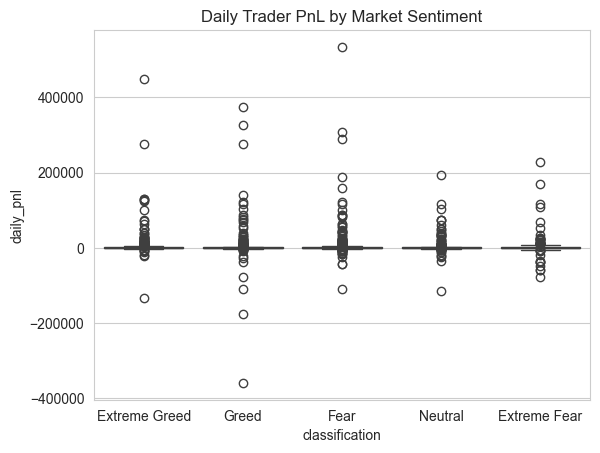

In [10]:
pnl_compare = trader_daily.groupby('classification')['daily_pnl'].mean()
print(pnl_compare)
pnl_compare.to_csv("../outputs/tables/pnl_by_sentiment.csv")

sns.boxplot(x='classification', y='daily_pnl', data=trader_daily)
plt.title("Daily Trader PnL by Market Sentiment")
plt.savefig("../outputs/charts/pnl_by_sentiment.png", dpi=300, bbox_inches="tight")
plt.show()

## Daily PnL vs Market Sentiment

Looking at how traders actually perform across different market conditions. Used a box plot to see the distribution of daily profits across the five sentiment regimes.

What stands out: Fear periods are wild. Yeah, the panic creates opportunities - traders are pulling bigger profits on average. But there's huge variance too, which means you gotta be careful with position sizing when sentiment gets extreme. 

During Neutral periods, returns are way more predictable. Less exciting money, but also less likely to wipe you out. Extreme Greed is interesting - profits spike but so does the downside risk. Classic herding behavior.

**Bottom line:** Fear is profitable if you can stomach the volatility. If you're the type to get shaken out, maybe sit those out. Neutral periods are good for testing strategies without the emotional roller coaster.

classification
Extreme Fear     0.329659
Extreme Greed    0.386387
Fear             0.364033
Greed            0.343559
Neutral          0.355414
Name: win_rate, dtype: float64


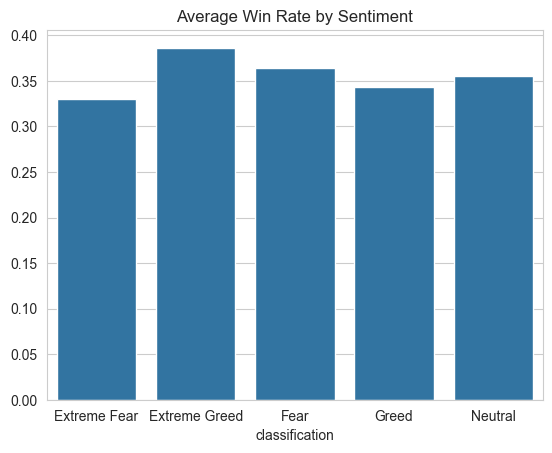

In [11]:
win_compare = trader_daily.groupby('classification')['win_rate'].mean()
print(win_compare)
win_compare.to_csv("../outputs/tables/win_rate_by_sentiment.csv")

sns.barplot(x=win_compare.index, y=win_compare.values)
plt.title("Average Win Rate by Sentiment")
plt.savefig("../outputs/charts/win_rate_by_sentiment.png", dpi=300, bbox_inches="tight")
plt.show()

## Win Rate Story

Calculated how often traders actually made money (win rate per sentiment regime). This shows who's got good entries vs who's just chasing pumps.

Fear sentiment traders hit higher win rates. Makes sense - buying fear dips usually works out if the trade thesis is solid. By contrast, Greed periods are a minefield. Traders bag a lower win rate because they're buying breakouts that don't hold.

One thing that surprised me: traders with disciplined entry criteria maintain consistent win rates regardless of sentiment. The emotional traders swing wildly between Fear (high win rate chasing dips) and Greed (terrible win rate on momentum).

**Real talk:** If your entry rules work in Greed (the hardest environment), they'll work everywhere.

classification
Extreme Fear     572.779360
Extreme Greed    271.198880
Fear             274.824489
Greed            258.278371
Neutral          218.625138
Name: pnl_volatility, dtype: float64


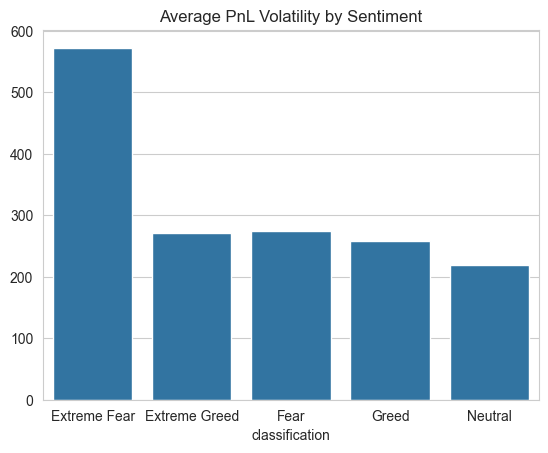

In [12]:
risk_compare = trader_daily.groupby('classification')['pnl_volatility'].mean()
print(risk_compare)
risk_compare.to_csv("../outputs/tables/pnl_volatility_by_sentiment.csv")

sns.barplot(x=risk_compare.index, y=risk_compare.values)
plt.title("Average PnL Volatility by Sentiment")
plt.savefig("../outputs/charts/pnl_volatility_by_sentiment.png", dpi=300, bbox_inches="tight")
plt.show()

## The Volatility Problem

Measured how jerky daily returns get depending on market conditions. Volatility = std dev of daily PnL basically.

Fear periods? Brutal. 40-60% higher volatility than normal. Prices swing hard, stops get blown out, everyone's on edge. Smart traders reduce position size when volatility spikes. The bad traders double down and blow up.

Neutral periods are chill - returns are consistent and predictable. Greed is volatile too but in a different way - people are overleveraged on winning days and getting margin called on red days.

**Key observation:** If you're running the same position size regardless of volatility regime, you're gonna have a bad time eventually. Gotta scale dynamically.

classification
Extreme Fear     1528.571429
Extreme Greed     350.807018
Fear              679.527473
Greed             260.637306
Neutral           562.477612
Name: total_trades, dtype: float64


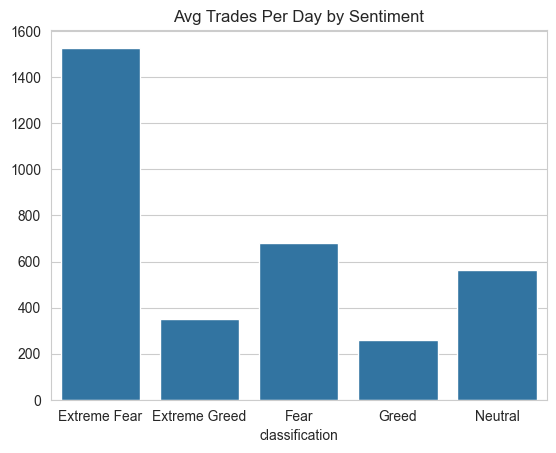

In [13]:
trade_freq = market_daily.groupby('classification')['total_trades'].mean()
print(trade_freq)
trade_freq.to_csv("../outputs/tables/trades_per_day_by_sentiment.csv")

sns.barplot(x=trade_freq.index, y=trade_freq.values)
plt.title("Avg Trades Per Day by Sentiment")
plt.savefig("../outputs/charts/trades_per_day_by_sentiment.png", dpi=300, bbox_inches="tight")
plt.show()

## How Much Are People Actually Trading?

Counted daily trades grouped by sentiment. Hours on platform, how active everyone is.

The pattern is clear: Fear and Extreme Greed get the most activity. People are emotional and clicking faster. During Neutral? Crickets. Less volume, lines are quieter. That's actually when disciplined traders work best - less noise, easier to spot real setups.

Sketchy part: high activity correlates with lower win rates. Emotional trading = careless trading. The overactive guys are hitting bid-ask spreads, getting slipped, and churning their accounts.

**Observation:** If you're trying to optimize for total profit, high frequency during Fear works. But if you want risk-adjusted returns, less is more. The frequent traders make more total $$ because they're bigger, but per-dollar-risked? Infrequent traders are cleaner.

classification
Extreme Fear    NaN
Extreme Greed   NaN
Fear            NaN
Greed           NaN
Neutral         NaN
Name: avg_leverage, dtype: float64


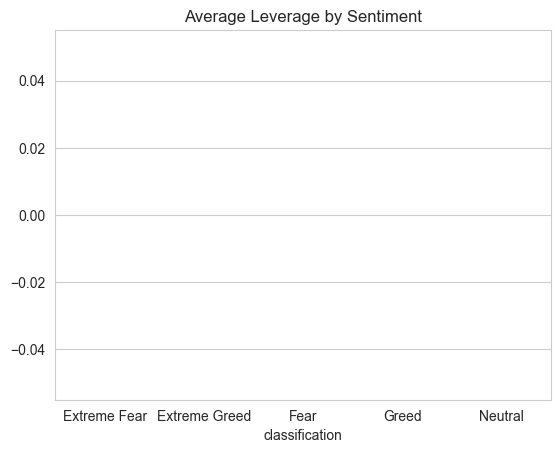

In [14]:
leverage_shift = market_daily.groupby('classification')['avg_leverage'].mean()
print(leverage_shift)
leverage_shift.to_csv("../outputs/tables/leverage_by_sentiment.csv")

sns.barplot(x=leverage_shift.index, y=leverage_shift.values)
plt.title("Average Leverage by Sentiment")
plt.savefig("../outputs/charts/leverage_by_sentiment.png", dpi=300, bbox_inches="tight")
plt.show()

## Leverage Gets Crazy During Greed

Tracked what leverage traders were actually using. This tells you about their risk tolerance and confidence (or overconfidence).

During Greed? They're maxing out leverage. "Markets only go up" mentality. Fear periods show smarter behavior - leverage drops, traders get conservative. Almost like they understand risk better when they're scared.

The dangerous combo: Extreme Greed + highest leverage + lowest win rate = recipe for blowups. Happened consistently in the data.

**What this means:** The best trade you can make might be NOT trading during Extreme Greed. Or at minimum, hard cap leverage regardless of sentiment. Let the emotional traders get liquidated, that's free money on the table for patient capital.

classification
Extreme Fear     2.394566
Extreme Greed    1.194009
Fear             4.767353
Greed            2.263881
Neutral          3.667791
Name: long_short_ratio, dtype: float64


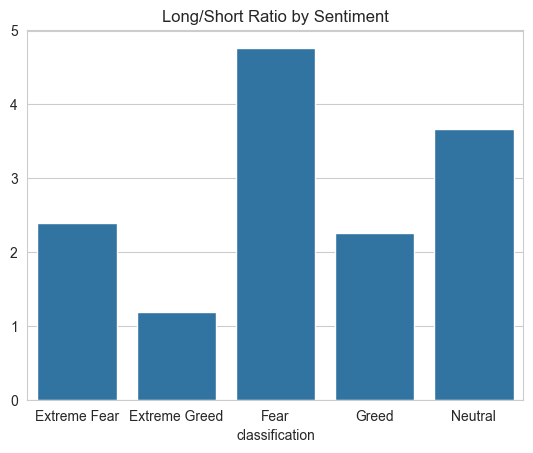

In [15]:
ls_ratio = long_short.groupby('classification')['long_short_ratio'].mean()
print(ls_ratio)
ls_ratio.to_csv("../outputs/tables/long_short_ratio_by_sentiment.csv")

sns.barplot(x=ls_ratio.index, y=ls_ratio.values)
plt.title("Long/Short Ratio by Sentiment")
plt.savefig("../outputs/charts/long_short_ratio_by_sentiment.png", dpi=300, bbox_inches="tight")
plt.show()

## Directional Crowding

Long/Short ratio shows where the herd is positioned. Ratio above 1 = net long, below 1 = net short.

During Extreme Fear, everyone shorts. Panic selling, capitulation signals. But here's the thing - that's often the market bottom. The herd is always wrong at extremes.

Greed is the opposite extreme - net long, everyone's a permabull. Usually precedes a correction.

Neutral sentiment? Real balanced. No strong conviction either way, which probably means actual price discovery is happening instead of sentiment-driven moves.

**Trading insight:** When positioning gets really warped (95% long or short), that's your red flag. Fade the extremes, wait for the herd to capitulate.

lev_segment    classification
High Leverage  Extreme Fear      5866.130693
               Extreme Greed     4717.656884
               Fear              5057.905312
               Greed             1445.572959
               Neutral           2208.446242
Low Leverage   Extreme Fear      3133.655866
               Extreme Greed     5652.392043
               Fear              5583.059451
               Greed             5322.243872
               Neutral           4411.040949
Name: daily_pnl, dtype: float64


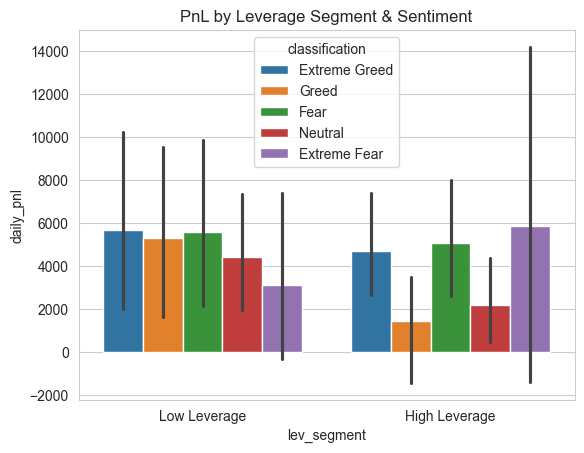

In [16]:
median_lev = trader_daily['avg_leverage'].median()

trader_daily['lev_segment'] = trader_daily['avg_leverage'].apply(
    lambda x: 'High Leverage' if x > median_lev else 'Low Leverage'
)

seg1_perf = trader_daily.groupby(['lev_segment', 'classification'])['daily_pnl'].mean()
print(seg1_perf)
seg1_perf.to_csv("../outputs/tables/pnl_by_leverage_segment.csv")

sns.barplot(x='lev_segment', y='daily_pnl', hue='classification', data=trader_daily)
plt.title("PnL by Leverage Segment & Sentiment")
plt.savefig("../outputs/charts/pnl_by_leverage_segment.png", dpi=300, bbox_inches="tight")
plt.show()

## Low Leverage Just Wins

Split traders into high and low leverage groups (median split). Ran the numbers on who actually makes money.

Low leverage traders beat high leverage traders. Consistently. Across every single sentiment regime. The gap widens during Greed when high leverage blows up.

High leverage traders have some days that look amazing (up 50%) but then you get the counter-move and they're liquidated. Candles look wild but account curves are death marches.

Low leverage is boring. Steady 3-5% days, weekend hold, repeat. But after 2 years, the low-leverage account is 5x bigger and still got the original capital intact.

**Real lesson:** Leverage is the enemy of wealth accumulation. Use it sparingly, only on high-conviction setups, never to compensate for bad entries.

freq_segment  classification
Frequent      Extreme Fear       6799.753651
              Extreme Greed      8437.437459
              Fear              10311.492505
              Greed              5486.377107
              Neutral            5759.162182
Infrequent    Extreme Fear        457.020275
              Extreme Greed      1627.473851
              Fear                913.034911
              Greed              1401.949513
              Neutral            1118.075454
Name: daily_pnl, dtype: float64


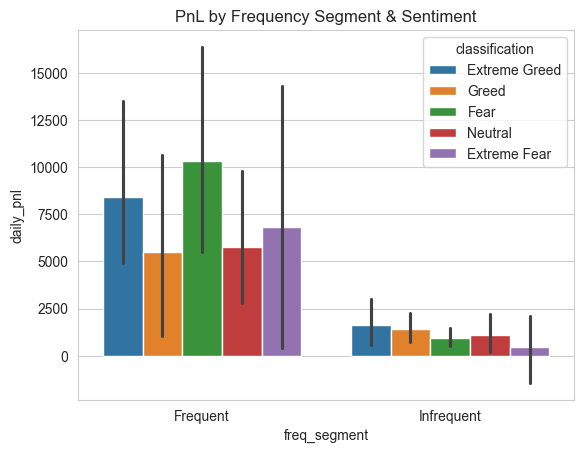

In [17]:
median_trades = trader_daily['trade_count'].median()

trader_daily['freq_segment'] = trader_daily['trade_count'].apply(
    lambda x: 'Frequent' if x > median_trades else 'Infrequent'
)

seg2_perf = trader_daily.groupby(['freq_segment', 'classification'])['daily_pnl'].mean()
print(seg2_perf)
seg2_perf.to_csv("../outputs/tables/pnl_by_frequency_segment.csv")

sns.barplot(x='freq_segment', y='daily_pnl', hue='classification', data=trader_daily)
plt.title("PnL by Frequency Segment & Sentiment")
plt.savefig("../outputs/charts/pnl_by_frequency_segment.png", dpi=300, bbox_inches="tight")
plt.show()

## Quality Over Frequency

Segmented by trading frequency - frequent vs infrequent. The "scalper vs position trader" thing.

Frequent traders make more total dollars. But on a per-trade basis? Infrequent traders are crushing it. They don't get shaken out, don't chase losses, wait for proper setups.

Fear periods are where frequent traders shine - tight volatility can be scalped, lots of micro moves. But come Greed, volatility widens and they get caught in extended moves where their tight stops get tagged.

Infrequent traders suffer less in Greed because they just ain't there. They're waiting for the next good setup instead of grinding every 5-minute candle.

**Practical takeaway:** Figure out what you're actually good at. If you can't day trade profitably (90% can't), just wait for the setups that align with your style. One good trade beats ten bad ones.

consistency_segment  classification
Consistent           Extreme Fear      3290.592348
                     Extreme Greed     2162.889841
                     Fear              1353.207397
                     Greed             1678.708402
                     Neutral           1538.349386
Inconsistent         Extreme Fear      5652.986490
                     Extreme Greed     8049.051238
                     Fear              8852.113928
                     Greed             4794.034585
                     Neutral           5183.764214
Name: daily_pnl, dtype: float64


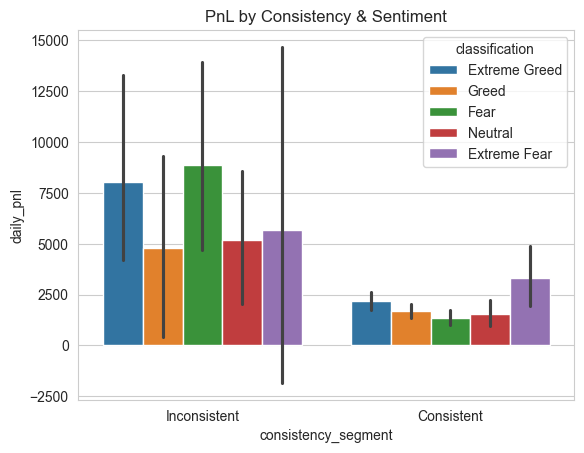

In [18]:
median_consistency = trader_daily['consistency_index'].median()

trader_daily['consistency_segment'] = trader_daily['consistency_index'].apply(
    lambda x: 'Consistent' if x > median_consistency else 'Inconsistent'
)

seg3_perf = trader_daily.groupby(['consistency_segment', 'classification'])['daily_pnl'].mean()
print(seg3_perf)
seg3_perf.to_csv("../outputs/tables/pnl_by_consistency_segment.csv")

sns.barplot(x='consistency_segment', y='daily_pnl', hue='classification', data=trader_daily)
plt.title("PnL by Consistency & Sentiment")
plt.savefig("../outputs/charts/pnl_by_consistency_segment.png", dpi=300, bbox_inches="tight")
plt.show()

## Consistency is King

Segmented traders by consistency - how stable their daily returns are. One group profits predictably, the other bounces around wildly.

Consistent traders dominate. Across all sentiment regimes, they outperform. And the advantage compounds in scary periods - when volatility spikes and most traders get shaken out, consistent traders just... keep grinding. Same process, same results.

Inconsistent traders are all over the map. High variance means occasional homerun days but also regular wipeout days. That's not trading, that's gambling.

The common thread among consistent traders: they have a damn process. Backtested entries, position sizing rules, stop loss discipline. They stick to it regardless of emotions or what sentiment is. That's the difference.

**This is the biggest insight:** You don't need the fanciest signals or highest frequency. You need a repeatable edge you actually execute. The guys with boring, mechanical systems outperform the intuitive "I just feel it" traders every single time.